In [9]:
import sys

import numpy as np
import osmnx as ox
import pandas as pd

ox.__version__

'2.0.1'

## Elevation from local raster file(s)

OSMnx can attach elevations to graph nodes using either a single raster file or a list of raster files. The latter creates a virtual raster VRT composed of the rasters at those filepaths. By default, it uses all available CPUs but you can configure this with an argument.

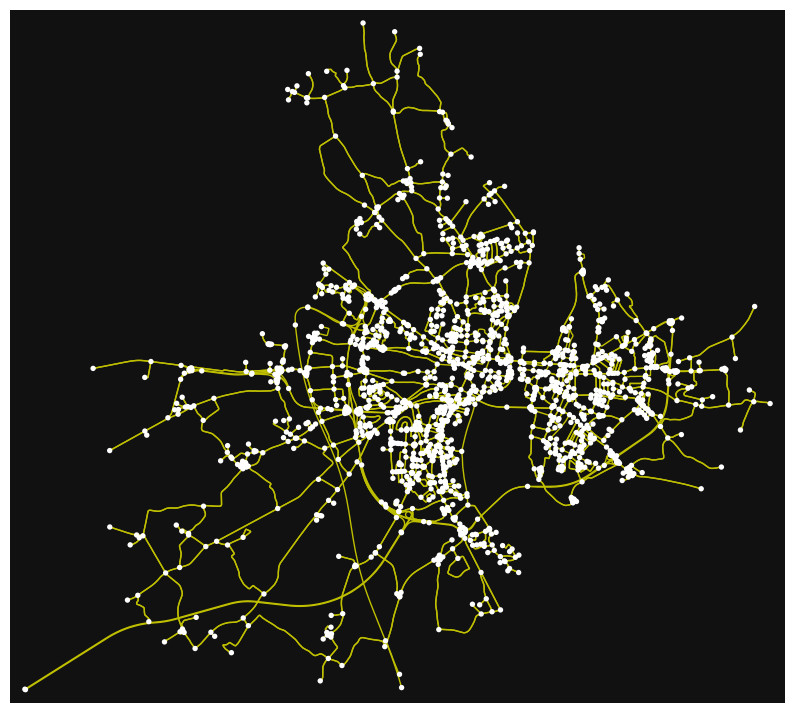

In [26]:
place = "Saintes, Nouvelle-Aquitaine"
G = ox.graph_from_place(place, network_type="drive", truncate_by_edge=True)
fig, ax = ox.plot.plot_graph(G, figsize=(10, 10), edge_color="y")

In [28]:
# Ajouter l'altitude aux noeuds
original_elevation_url = ox.settings.elevation_url_template
ox.settings.elevation_url_template = (
    "https://api.opentopodata.org/v1/aster30m?locations={locations}"
)
G = ox.elevation.add_node_elevations_google(G, batch_size=100, pause=1)
G = ox.elevation.add_edge_grades(G)
ox.settings.elevation_url_template = original_elevation_url

In [29]:
gdf_nodes, gdf_edges = ox.graph_to_gdfs(G)

In [30]:
G = ox.elevation.add_edge_grades(G, add_absolute=True)

## Plot the nodes by elevation

Plot them colored from low (violet) to high (yellow).

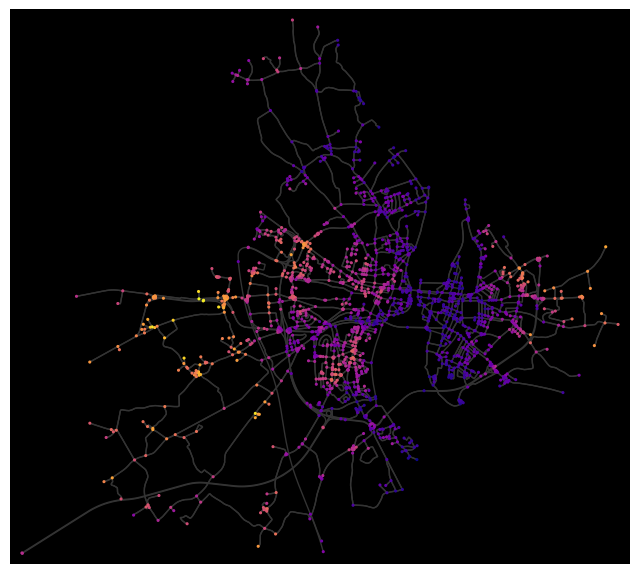

In [31]:
# get one color for each node, by elevation, then plot the network
nc = ox.plot.get_node_colors_by_attr(G, "elevation", cmap="plasma")
fig, ax = ox.plot.plot_graph(G, node_color=nc, node_size=5, edge_color="#333333", bgcolor="k")

## Plot the edges by grade

Grade is the ratio of elevation change to edge length. Plot edges colored from low/flat (violet) to high/steep (yellow).

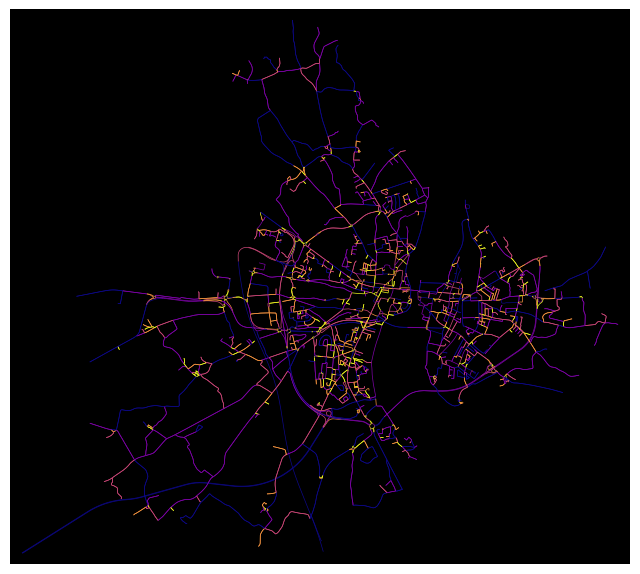

In [32]:
# get a color for each edge, by grade, then plot the network
ec = ox.plot.get_edge_colors_by_attr(G, "grade_abs", cmap="plasma", num_bins=5, equal_size=True)
fig, ax = ox.plot.plot_graph(G, edge_color=ec, edge_linewidth=0.5, node_size=0, bgcolor="k")

## Calculate some summary stats

Use an undirected representation of the network so we don't overcount two-way streets (because they have reciprocal edges pointing in each direction). We use the absolute value of edge grade because we're interested in steepness, not directionality.

In [33]:
# calculate the edges' absolute grades (and drop any infinite/null values)
grades = pd.Series([d["grade_abs"] for _, _, d in ox.convert.to_undirected(G).edges(data=True)])
grades = grades.replace([np.inf, -np.inf], np.nan).dropna()

In [34]:
avg_grade = np.mean(grades)
print(f"Average street grade in {place} is {avg_grade * 100:.1f}%")

med_grade = np.median(grades)
print(f"Median street grade in {place} is {med_grade * 100:.1f}%")

Average street grade in Saintes, Nouvelle-Aquitaine is 5.4%
Median street grade in Saintes, Nouvelle-Aquitaine is 3.6%


## Calculate shortest paths, considering grade impedance

This example approximates the route of "The Wiggle" in San Francisco.

In [40]:
# select an origin and destination node and a bounding box around them
origin = ox.distance.nearest_nodes(G, -0.641775, 45.747967)
destination = ox.distance.nearest_nodes(G, -0.642589, 45.738988)

In [41]:
route_by_length = ox.routing.shortest_path(G, origin, destination, weight="length")

#### Now find the shortest path that avoids slopes by minimizing *impedance* (function of length and grade):

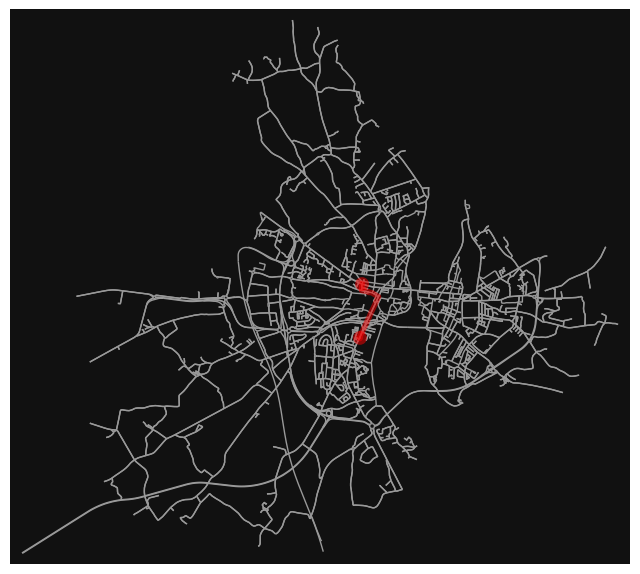

In [42]:
fig, ax = ox.plot.plot_graph_route(G, route_by_length, node_size=0)